# Grover Search Algorithm Example

We implement a permutation
\begin{align*}
    (0~~2) =
    \begin{pmatrix}
        0 & 1 & 2 & 3 \\
        2 & 1 & 0 & 3
    \end{pmatrix}
\end{align*}
on a quantum circuit with $4+4$ qubits:
\begin{align*}
    & f\colon x_3x_2x_1x_0 \mapsto x_3x_0x_1x_2, \quad x_0,x_1,x_2,x_3\in\{0,1\},\\[.5em]
    & U_f\colon |x_3x_2x_1x_0\rangle|0000\rangle \mapsto |x_3x_2x_1x_0\rangle|f(x_3x_2x_1x_0)\rangle.
\end{align*}
In what follows, we assume that the function $f$ implemented on the circuit is not explicitly defined, i.e., the gate $U_f$ is treated as an oracle.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile
from qiskit.circuit.library import XGate, GroverOperator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import copy

In [2]:
backend = AerSimulator()

The oracle $U_f$ is as follows.

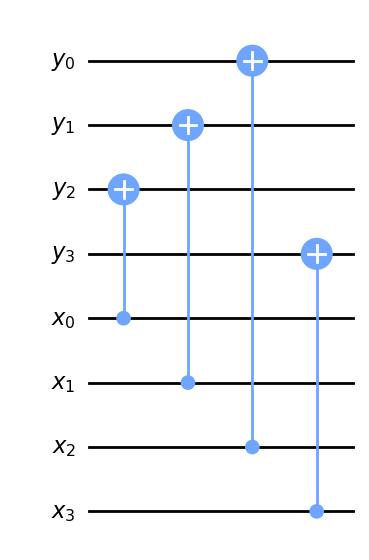

In [3]:
N = 4
nx_qubits, ny_qubits = N, N
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qc = QuantumCircuit(qr_y, qr_x)

# |x3>|x2>|x1>|x0>|0000> -> |x3>|x2>|x1>|x0>|x3>|x0>|x1>|x2>
for i in range(nx_qubits):
    qc.cx(i + ny_qubits, (ny_qubits - 2 - i) % ny_qubits)

Uf = qc.to_gate()
Uf.name = '   $U_f$   '
qc.draw('mpl')

In [4]:
nx_qubits, ny_qubits = N, N
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qc = QuantumCircuit(qr_y, qr_x)

# |x3>|x2>|x1>|x0>|0000> -> |x3>|x2>|x1>|x0>|x3>|x0>|x1>|x2>
for i in range(nx_qubits):
    qc.h(i + ny_qubits)

qc.append(Uf, qargs=range(ny_qubits + nx_qubits))
U_prep = qc.to_gate()
U_prep.name = '$U_{prep}$'

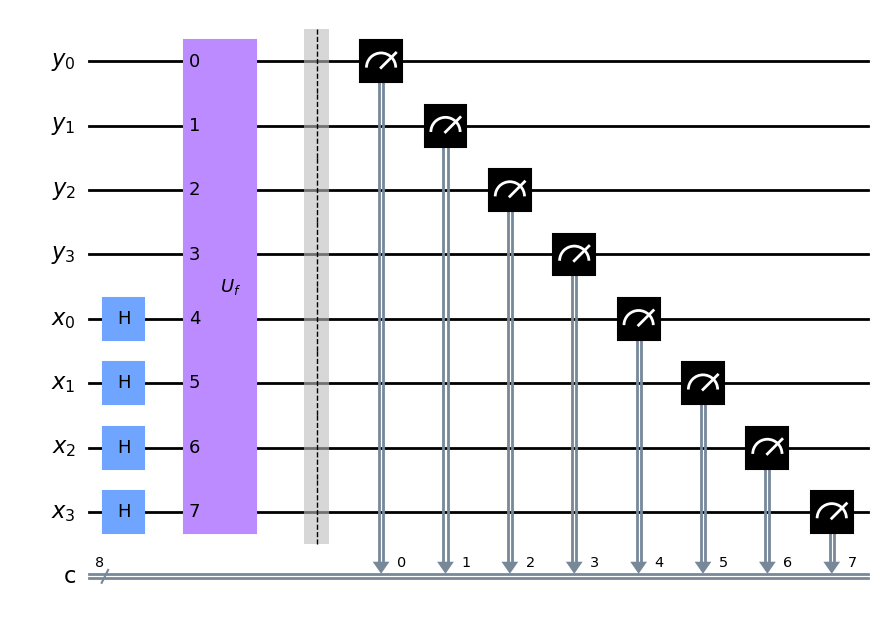

In [5]:
nx_qubits, ny_qubits = N, N
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qc = QuantumCircuit(qr_y, qr_x)

qc.append(U_prep, qargs=range(ny_qubits + nx_qubits))

qc.barrier()
cr = ClassicalRegister(nx_qubits + ny_qubits, 'c')
qc.add_register(cr)
qc.measure(list(range(nx_qubits + ny_qubits)), cr)
qc.decompose().draw('mpl')

{'01010101': 601, '10101010': 595, '10111110': 584, '11101011': 597, '01100011': 629, '11011101': 643, '10011100': 640, '11001001': 611, '00110110': 582, '00100010': 615, '11111111': 632, '10001000': 654, '01110111': 649, '00010100': 724, '01000001': 642, '00000000': 602}


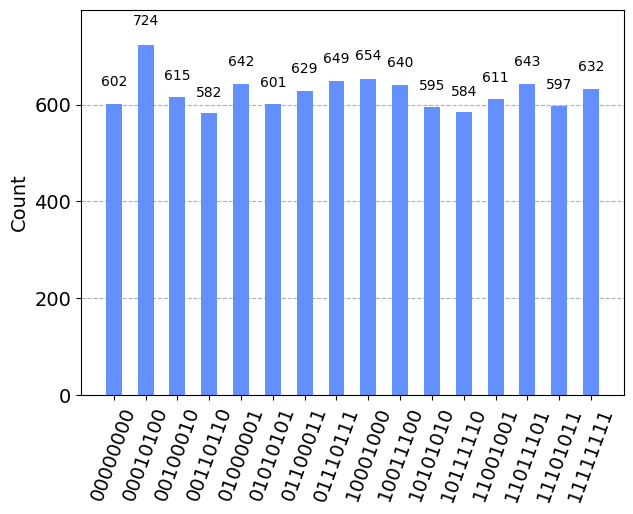

In [6]:
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_histogram(counts)

As an example, we search for a bitstring where $f$ attains $1100$.
We introduce additional ancilla qubits, and flip qubit No. 0 ("marker") to $|1\rangle$ when $f$ takes the value $1100$.
The circuit diagram for this is as follows.

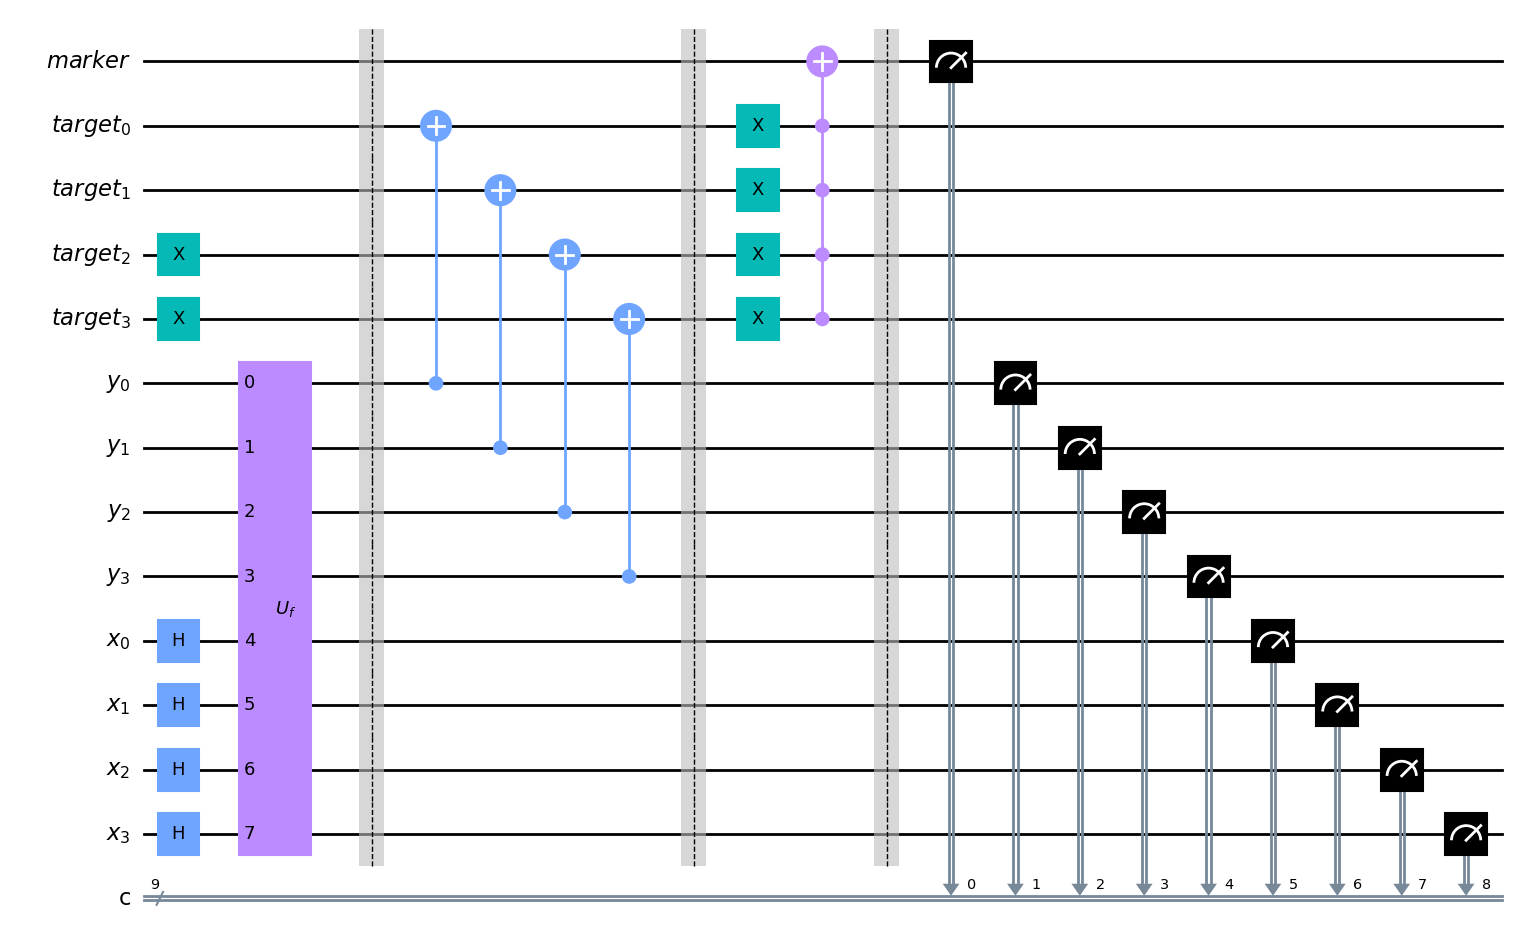

In [7]:
n_targets = nx_qubits
n_markers = 1
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qr_target = QuantumRegister(n_targets, 'target')
qr_marker = QuantumRegister(n_markers, 'marker')
qc = QuantumCircuit(qr_marker, qr_target, qr_y, qr_x)

# preparing state
qc.append(U_prep, qargs=range(n_markers + n_targets, n_markers + n_targets + ny_qubits + nx_qubits))

# target: |1100>
qc.x(n_markers + 2)
qc.x(n_markers + 3)

# check y=target
qc.barrier()
for i in range(nx_qubits):
    qc.cx(i + n_targets + n_markers, i + n_markers)

# marking on the qubit "marker"
qc.barrier()
for i in range(n_targets):
    qc.x(i + n_markers)
c4x_gate = XGate().control(4)
qc.append(c4x_gate, qargs=reversed(range(n_targets + n_markers)))

qc.barrier()
cr = ClassicalRegister(n_markers + nx_qubits + ny_qubits, 'c')
qc.add_register(cr)
qc.measure([0, 5, 6, 7, 8, 9, 10, 11, 12], cr)

qc.decompose(gates_to_decompose='$U_{prep}$').draw('mpl')
# qc.draw('mpl', filename='test.jpg')

{'110111010': 638, '110010010': 638, '000000000': 670, '010101010': 663, '000101000': 586, '010000010': 609, '011000110': 612, '100010000': 602, '001000100': 625, '111010110': 636, '111111110': 649, '101111100': 615, '001101100': 634, '100111001': 620, '011101110': 615, '101010100': 588}


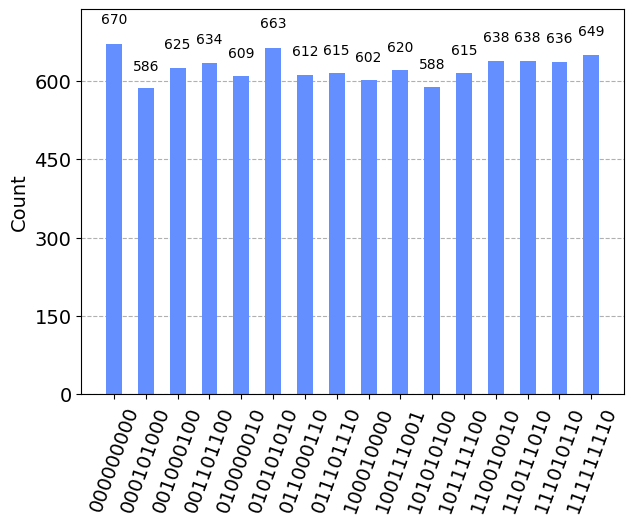

In [8]:
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_histogram(counts)
# plot_histogram(counts, filename='test.jpg')

As can be seen from the histgram above, we observe that qubit No. 0 takes the state $|1\rangle$ when $|f(x_3x_2x_1x_0)\rangle$ equals $|1100\rangle$.

In the following, we set a Grover operator $Q$ for this problem.
The state preparation gate is the same as the one used above, and is as follows:

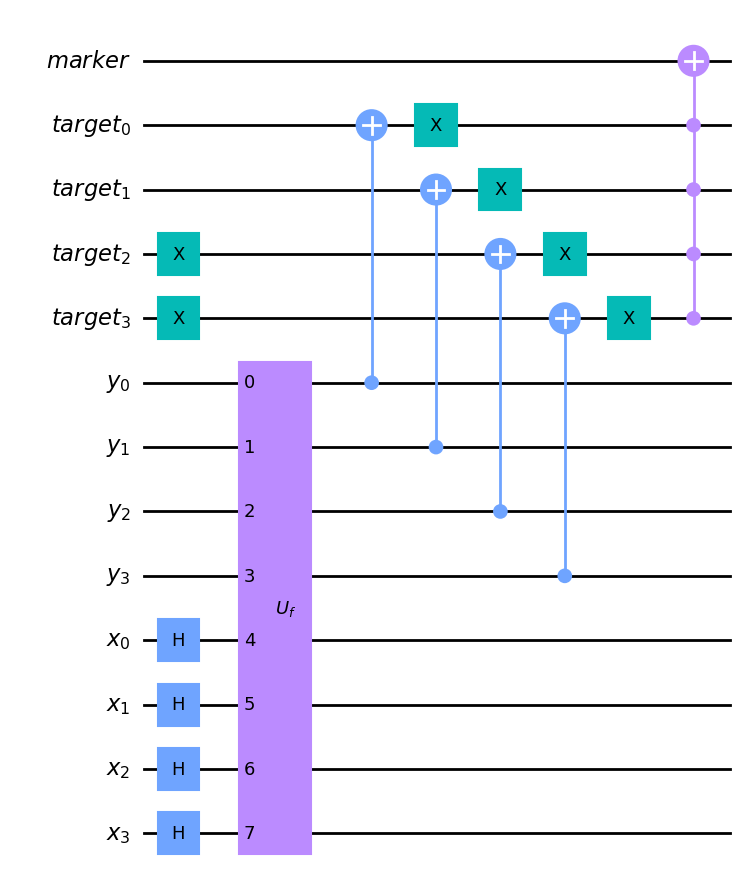

In [9]:
insert_barrier = False

qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qr_target = QuantumRegister(n_targets, 'target')
qr_marker = QuantumRegister(n_markers, 'marker')
qc = QuantumCircuit(qr_marker, qr_target, qr_y, qr_x)

# preparing state
qc.append(U_prep, qargs=range(n_markers + n_targets, n_markers + n_targets + ny_qubits + nx_qubits))

# target: |1100>
qc.x(n_markers + 2)
qc.x(n_markers + 3)

# check y=target
if insert_barrier: qc.barrier()
for i in range(nx_qubits):
    qc.cx(i + n_targets + n_markers, i + n_markers)

# marking on the qubit "marker"
if insert_barrier: qc.barrier()
for i in range(n_targets):
    qc.x(i + n_markers)
c4x_gate = XGate().control(4)
qc.append(c4x_gate, qargs=reversed(range(n_targets + n_markers)))

qc.decompose(gates_to_decompose='$U_{prep}$').draw('mpl')

Set a Grover operator $Q$.

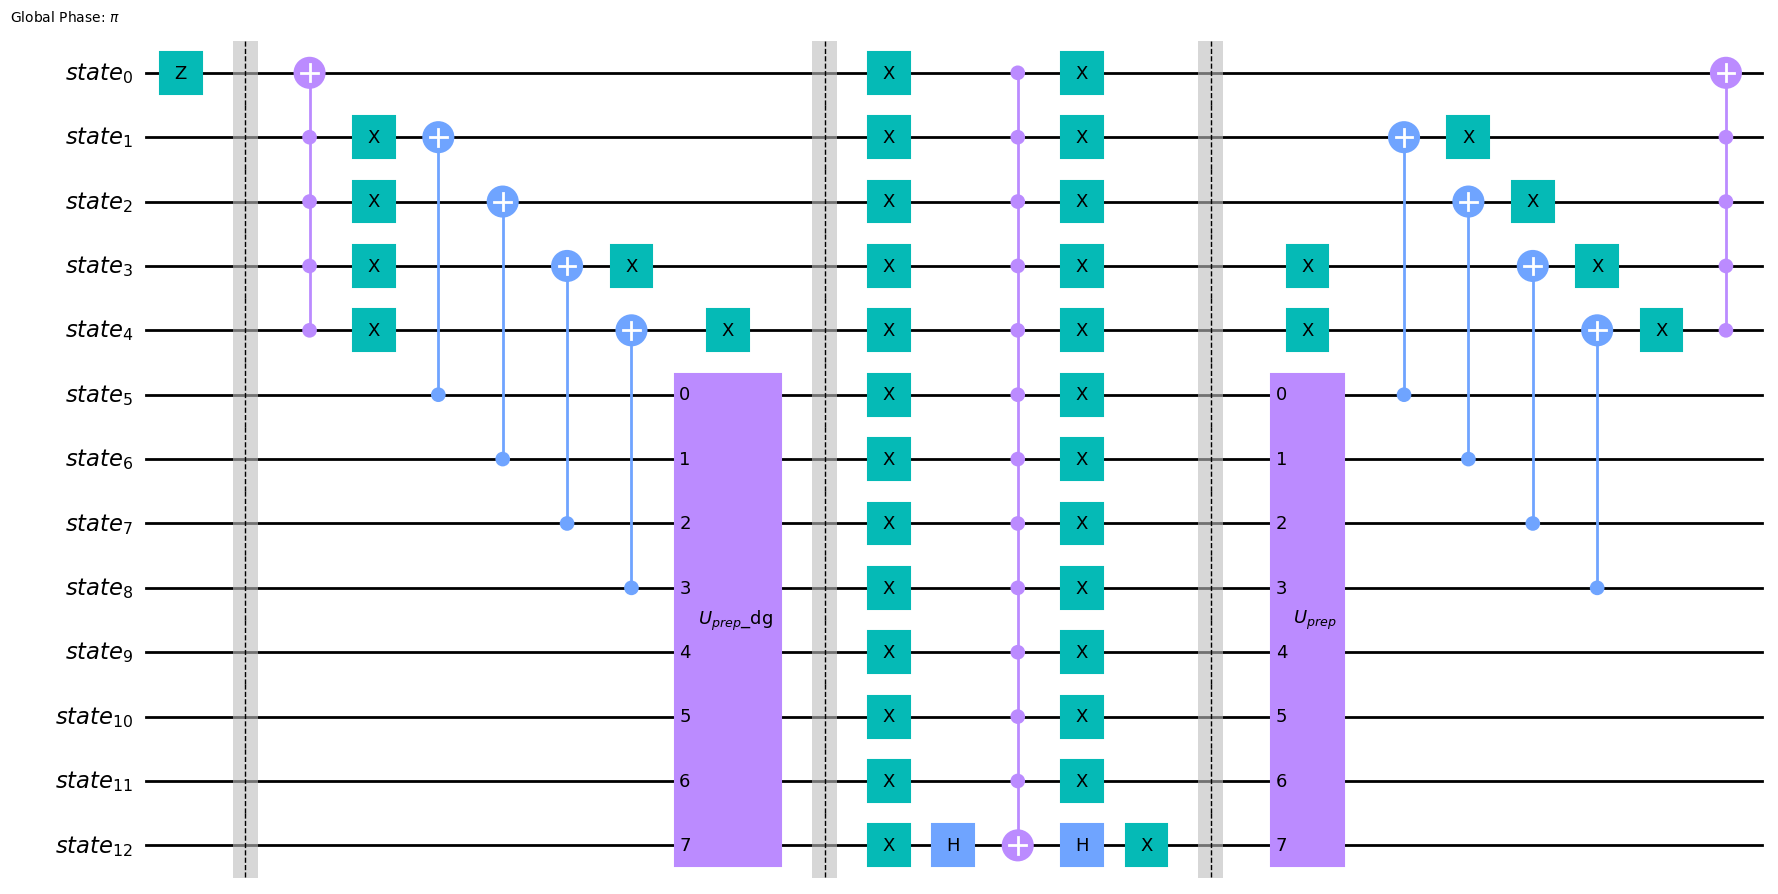

In [10]:
oracle = QuantumCircuit(n_targets + n_markers + nx_qubits + ny_qubits)
oracle.z(0)
Q = GroverOperator(oracle, state_preparation=qc, insert_barriers=True)
Q.decompose().draw('mpl')

The number of iterations for $Q$ is $\lfloor \pi/(4\arcsin \sqrt{2^{-4}}) \rfloor=3$ since the probability of  observing $|1100\rangle$ is $1/2^4$.

number of iterations: 3


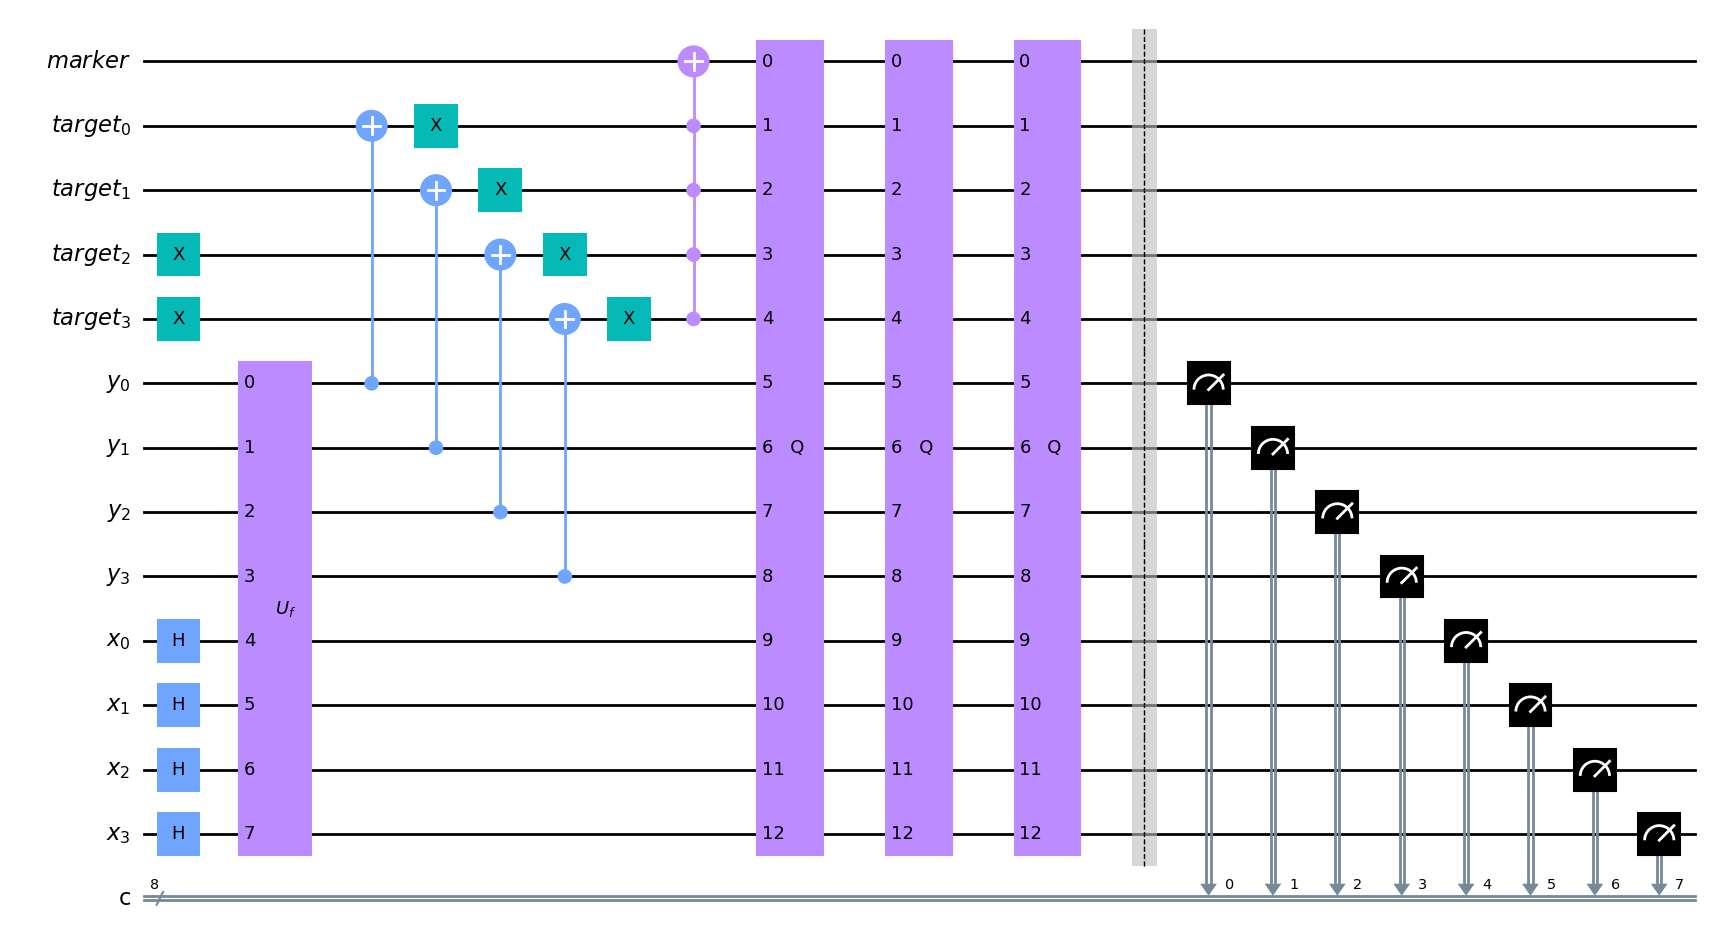

In [11]:
_qc = copy.deepcopy(qc)
n_iter = int(np.floor(np.pi / 4 / np.arcsin(np.sqrt(1 / 2 ** nx_qubits))))
print(f'number of iterations: {n_iter}')

Q = GroverOperator(oracle, state_preparation=qc, insert_barriers=False)
Q.name = '   Q   '

for i in range(n_iter):
    _qc.append(Q.to_gate(), qargs=range(n_targets + n_markers + nx_qubits + ny_qubits))

_qc.barrier()
cr = ClassicalRegister(nx_qubits + ny_qubits, 'c')
_qc.add_register(cr)
_qc.measure([5, 6, 7, 8, 9, 10, 11, 12], cr)

_qc.decompose(gates_to_decompose='$U_{prep}$').draw('mpl')

{'11011101': 20, '10011100': 9604, '10101010': 25, '00000000': 29, '11001001': 24, '01000001': 29, '11101011': 28, '10111110': 21, '00110110': 26, '10001000': 32, '11111111': 28, '00010100': 27, '01100011': 28, '01110111': 29, '01010101': 26, '00100010': 24}


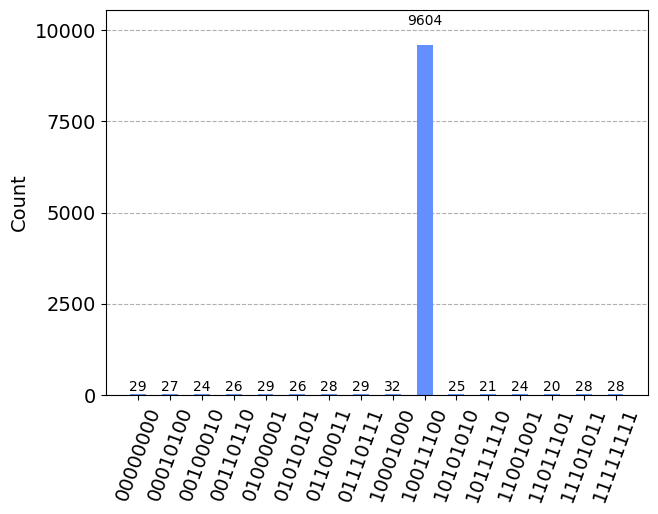

In [12]:
qc_compiled = transpile(_qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_histogram(counts)

We can see that the probability of observing $|f(x_3x_2x_1x_0)\rangle=|1100\rangle$ has been increased, and as a result, we can get $x=1001$ as the answer for satisfying $f(x)=1100$.